In [1]:
import pandas as pd
import numpy as np
import bpe
import seaborn as sns
import re
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt

import pickle

## Загрузим данные

In [2]:
train_data = pd.read_csv('./data/train.csv')

#### Добавим к таргетам колонку, означающую, что во фразе есть хотя бы какой-то неприятный контент

In [3]:
labels_column = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [4]:
train_data['toxic_content'] = train_data[labels_column].values.sum(axis=1)
train_data['toxic_content'][train_data['toxic_content'] > 1] = 1

/home/michael/.virtualenv/DS3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
train_data[labels_column + ['toxic_content']].to_csv('./processed/labels.csv', index=False)

In [6]:
train_data[:10]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_content
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,1
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,0


#### Посмотрим на корреляции таргетов

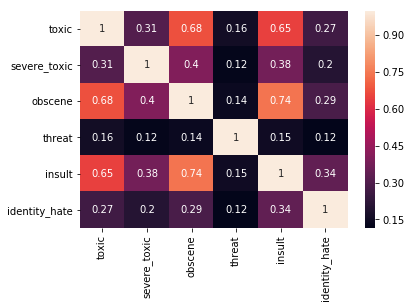

In [7]:
sns.heatmap(train_data[labels_column].corr(), annot=True)

### Начнем процессинг текстов

в качестве токенезатора возьмем byte pair encoding (bpe), так как он умеет хорошо стравлятся с неизвестныйми сущностями

In [14]:
texts = list(train_data.comment_text)
texts[:3]

["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."]

In [15]:
# функция процессинга строки, уберем \n и заменим все цифры на токен цифры
def lineProcessing(line):
    line = line.lower()
    line = line.replace('\n', '. ')
    __num = re.compile('[0-9]+')
    line = re.sub(__num, 'NUM', line)
    return line

In [16]:
%%time

texts = list(map(lineProcessing, texts))

CPU times: user 1.52 s, sys: 2.21 ms, total: 1.53 s
Wall time: 1.52 s


In [17]:
texts[:3]

["explanation. why the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.NUM.NUM.NUM.NUM",
 "d'aww! he matches this background colour i'm seemingly stuck with. thanks.  (talk) NUM:NUM, january NUM, NUM (utc)",
 "hey man, i'm really not trying to edit war. it's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. he seems to care more about the formatting than the actual info."]

87 квантиль длиный строк в символах

In [18]:
np.quantile([len(x) for x in texts], 0.87)

741.0

####  создадим encoder и обучим его на наших текстах

In [19]:
encoder = bpe.Encoder()

In [20]:
%%time

encoder.fit(text=texts)

CPU times: user 13 s, sys: 94.5 ms, total: 13.1 s
Wall time: 13.1 s


In [21]:
pickle.dump(encoder, open('./processed/pbe_encoder.pkl', 'wb'))

#### токенезируем все тексты и сохраним

In [22]:
%%time

tokens = list(map(encoder.tokenize, texts))

CPU times: user 8.89 s, sys: 210 ms, total: 9.1 s
Wall time: 9.1 s


In [23]:
%%time

rnn_features = list(encoder.transform(texts))

CPU times: user 12.5 s, sys: 78 ms, total: 12.6 s
Wall time: 12.6 s


In [24]:
pickle.dump(rnn_features, open('./processed/rnn_features.pkl', 'wb'))

#### посмотрим на распределение текстов по количеству токенов

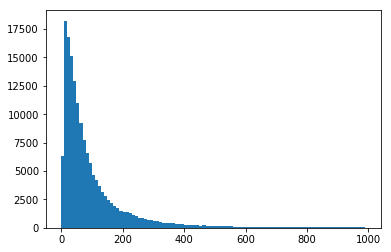

In [25]:
plt.hist([len(x) for x in rnn_features], bins=np.arange(0, 1000, 10))
plt.show()

#### хочется попробовать один из очевидно интропретируемых подходов - модели на деревьях решений

Для этого нужно превратить наши фичи в вектора фиксированного размера для каждого текста. Для небольших текстов, таких как весь наш датасет, препроцессинг и выделение фичей является особенно важным этапом и по-хорошему нужно было бы поексперементировать с этой частью модели. К сожалению у меня довольно мало времени на это :(

In [26]:
vectorizer = CountVectorizer()

In [27]:
%%time

features = vectorizer.fit_transform(' '.join(x) for x in tokens)

CPU times: user 8.26 s, sys: 156 ms, total: 8.41 s
Wall time: 8.54 s


In [28]:
pickle.dump(features, open('./processed/bpe_8000_features.pkl', 'wb'))